In [268]:
# OpenAI gym library provides models for the environment on which we can apply RL algos
import gym
import numpy as np
import pandas as pd
import seaborn as sns

# Problem Statement
https://gym.openai.com/envs/Taxi-v3/

In [104]:
env = gym.make('Taxi-v3')
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



* The above visual shows an area which has been divided into 5x5 grid
* There is a self driving taxi (indicated by yellow mark when empty and green mark when passenger has occupied it).
* The job for self driving taxi is to pick up the passenger at one of the 4 locations and drop off in another location

In [74]:
from gym.envs.toy_text.taxi import TaxiEnv
print(TaxiEnv.__doc__)


    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich

    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

    Observations: 
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
    
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y

# How do we solve this problem using Reinforcement Learning?

Lets set the terminology right  

Environment: 5x5 space in which the taxi ferries the passenger from pickup to drop location (universe in which the agent performs action and learns)  
Agent: Taxi (learner)  
Action: Taxi moves 1 grid east/west/north/south or picks/drops passenger  
State: One of the 500 possible states of the environment with a specific position of taxi and passenger  
Reward: -1 for each action, +20 for correct drop off, -10 for incorrect drop-off 

RL - Solve the problem of maximizing the reward

Lets use the Q-learning algorithm to solve this problem

In [173]:
# There are 500 possible states and 6 possible actions
print(env.env.observation_space)
print(env.action_space)

Discrete(500)
Discrete(6)


In [174]:
## Lets look at step by step navigation to better understand the environment

env.env.s = 492
env.render()

#Move West
env.step(3)
env.render()

env.step(4)
env.render()

env.step(1)
env.render()

env.step(1)
env.step(3)
env.step(3)
env.step(3)
env.step(1)
env.step(1)
env.render()

env.step(5)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


## Lets try to solve the problem by brute force

In [273]:
reward = 0
total_reward = 0
steps = 0
env.reset()
while reward!=20:
    _, reward, _, _ = env.step(env.env.action_space.sample())
    total_reward += reward
    steps+=1
print(steps, total_reward)

1256 -4817


# Solve the problem using q-learning
https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html#a-taxonomy-of-rl-algorithms

In [335]:
#Initialize Q table with zeros
Q = np.zeros((env.env.observation_space.n, env.action_space.n))
print(Q.shape)
print (Q)

(500, 6)
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [328]:
alpha = 0.5
gamma = 0.8
episodes = 1000
Q = np.zeros((env.env.observation_space.n, env.action_space.n))

learning = {}
for episode in range(episodes):
    cur_state = env.reset()
    reward = 0
    total_reward = 0
    done = False
    while not done:
        #action = env.env.action_space.sample()
        action = np.argmax(Q[cur_state])
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        Q[cur_state][action] += alpha*(reward + gamma*(np.max(Q[next_state]) - Q[cur_state][action]))
        cur_state = next_state
    learning[episode] = total_reward
    if episode % 100 == 0:
        print(total_reward)

-560
-152
11
9
-2
11
3
6
4
8


In [338]:
df = pd.DataFrame(learning.items())
df.head()

,0,1
0,0,-560
1,1,-596
2,2,-542
3,3,-524
4,4,-524


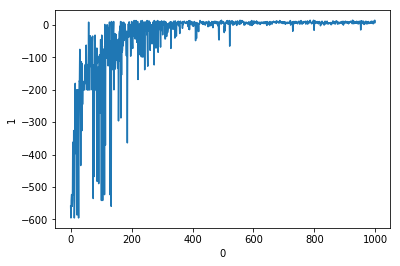

In [339]:
sns.lineplot(x = 0, y = 1, data = df)

In [334]:
# Q table after training
Q

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -6.12747089,  -6.        ,  -5.77417802,  -6.        ,
         13.75      , -10.        ],
       [ -3.8317888 ,  -4.        ,  -4.12838784,  -4.        ,
         18.75      ,  -5.        ],
       ...,
       [ -2.5       ,  -0.4495936 ,  -2.5       ,  -2.9008192 ,
         -5.        ,  -5.        ],
       [ -4.        ,  -4.02975872,  -4.        ,  -4.41027226,
         -5.        ,  -5.        ],
       [ -1.        ,  -1.        ,  -1.        ,   3.2       ,
         -5.        ,  -5.        ]])

In [333]:
reward = 0
total_reward = 0
steps = 0
s = env.reset()
env.render()
done = False
while not done:
    action = np.argmax(Q[s])
    s, reward, done, _ = env.step(action)
    total_reward += reward
    steps+=1
env.render()
print(steps, total_reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
14 7


In [331]:
what is q in q learning
print q table
how to evaluate the performance of the model
what are the othe algos
to which type of problems can RI be applied? problems of maximization?
* env, agent, action, state, reward
* model free vs model based
* off-policy vs on-policy
* Q-learning, SARSA,

SyntaxError: invalid syntax (<ipython-input-331-111ec495c825>, line 1)